In [ ]:
# Set up plotting options
%matplotlib inline

In [ ]:
# load packages
import os
import sys
import cv2
import gdown
import numpy as np
import pandas as pd
from glob import glob
import torch.nn as nn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

import torch
from torch.utils.data import Dataset, DataLoader

# Download dataset

In [ ]:
# check if files are already downloaded
dset_download = os.path.isdir('/content/2021')

if dset_download is False:
  url = 'https://drive.google.com/uc?id=14HqNW5uWLS92n7KrxKgDwUTsSEST6LCr'
  output = 'train.tgz'
  gdown.download(url, output, quiet=False)

  url = 'https://drive.google.com/uc?id=1GWl3g1G152Rinxc1Fbc-JkSWlRQNWKBK'
  output = 'valid.tgz'
  gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=14HqNW5uWLS92n7KrxKgDwUTsSEST6LCr
To: /content/train.tgz
100%|██████████| 3.23G/3.23G [00:44<00:00, 73.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1GWl3g1G152Rinxc1Fbc-JkSWlRQNWKBK
To: /content/valid.tgz
100%|██████████| 873M/873M [00:19<00:00, 44.1MB/s]


In [ ]:
# path to dataset root directory
dset_root = '/content/2021/'

# Helper functions

In [ ]:
def get_filename(filepath):
    return os.path.split(filepath)[1]


def visualize(df_row, figsize=[25, 15]):
    # get image paths
    vv_image_path = df_row['vv_image_path']
    vh_image_path = df_row['vh_image_path']
    flood_label_path = df_row['flood_label_path']
    water_body_label_path = df_row['water_body_label_path']

    # create RGB image from S1 images
    rgb_name = get_filename(vv_image_path)
    vv_image = cv2.imread(vv_image_path, 0) / 255.0
    vh_image = cv2.imread(vh_image_path, 0) / 255.0
    rgb_image = s1_to_rgb(vv_image, vh_image)

    # get water body label mask
    water_body_label_image = cv2.imread(water_body_label_path, 0) / 255.0

    # plot images
    plt.figure(figsize=tuple(figsize))
    if df_row.isnull().sum() > 0:
        # plot RGB S1 image
        plt.subplot(1,2,1)
        plt.imshow(rgb_image)
        plt.title(rgb_name)

        # plot water body mask
        plt.subplot(1,2,2)
        plt.imshow(water_body_label_image)
        plt.title('Water body mask')
    else:
        flood_label_image = cv2.imread(flood_label_path, 0) / 255.0

        # plot RGB S1 image
        plt.subplot(1,3,1)
        plt.imshow(rgb_image)
        plt.title(rgb_name)

        # plot flood label mask
        plt.subplot(1,3,2)
        plt.imshow(flood_label_image)
        plt.title('Flood mask')

        # plot water body mask
        plt.subplot(1,3,3)
        plt.imshow(water_body_label_image)
        plt.title('Water body mask')


def s1_to_rgb(vv_image, vh_image):
    ratio_image = np.clip(np.nan_to_num(vh_image/vv_image, 0), 0, 1)
    rgb_image = np.stack((vv_image, vh_image, 1-ratio_image), axis=2)
    return rgb_image

def visualize_result(df_row, prediction, figsize=[25, 15]):
    vv_image = cv2.imread(df_row['vv_image_path'], 0) / 255.0
    vh_image = cv2.imread(df_row['vh_image_path'], 0) / 255.0
    rgb_input = s1_to_rgb(vv_image, vh_image)

    plt.figure(figsize=tuple(figsize))
    plt.subplot(1,2,1)
    plt.imshow(rgb_input)
    plt.title('RGB w/ result')
    plt.subplot(1,2,2)
    plt.imshow(prediction)
    plt.title('Result')

# Create training and validation dataframes

In [ ]:
vv_image_paths = sorted(glob(train_dir+'/**/vv/*.png', recursive=True))
vv_image_names = [get_filename(pth) for pth in vv_image_paths]
region_name_dates = ['_'.join(n.split('_')[:2]) for n in vv_image_names]


vh_image_paths, flood_label_paths, water_body_label_paths, region_names = [], [], [], []
for i in range(len(vv_image_paths)):
    # get vh image path
    vh_image_name = vv_image_names[i].replace('vv', 'vh')
    vh_image_path = os.path.join(train_dir, region_name_dates[i], 'tiles', 'vh', vh_image_name)
    vh_image_paths.append(vh_image_path)

    # get flood mask path
    flood_image_name = vv_image_names[i].replace('_vv', '')
    flood_label_path = os.path.join(train_dir, region_name_dates[i], 'tiles', 'flood_label', flood_image_name)
    flood_label_paths.append(flood_label_path)

    # get water body mask path
    water_body_label_name = vv_image_names[i].replace('_vv', '')
    water_body_label_path = os.path.join(train_dir, region_name_dates[i], 'tiles', 'water_body_label', water_body_label_name)
    water_body_label_paths.append(water_body_label_path)

    # get region name
    region_name = region_name_dates[i].split('_')[0]
    region_names.append(region_name)


train_paths = {'vv_image_path': vv_image_paths,
        'vh_image_path': vh_image_paths,
        'flood_label_path': flood_label_paths,
        'water_body_label_path': water_body_label_paths,
        'region': region_names
}


train_df = pd.DataFrame(train_paths)

In [ ]:
vv_image_paths = sorted(glob(valid_dir+'/**/vv/*.png', recursive=True))
vv_image_names = [get_filename(pth) for pth in vv_image_paths]
region_name_dates = ['_'.join(n.split('_')[:2]) for n in vv_image_names]


vh_image_paths, flood_label_paths, water_body_label_paths, region_names = [], [], [], []
for i in range(len(vv_image_paths)):
    # get vh image path
    vh_image_name = vv_image_names[i].replace('vv', 'vh')
    vh_image_path = os.path.join(valid_dir, region_name_dates[i], 'tiles', 'vh', vh_image_name)
    vh_image_paths.append(vh_image_path)

    # get flood mask path ()
    flood_label_paths.append(np.NaN)

    # get water body mask path
    water_body_label_name = vv_image_names[i].replace('_vv', '')
    water_body_label_path = os.path.join(valid_dir, region_name_dates[i], 'tiles', 'water_body_label', water_body_label_name)
    water_body_label_paths.append(water_body_label_path)

    # get region name
    region_name = region_name_dates[i].split('_')[0]
    region_names.append(region_name)

valid_paths = {'vv_image_path': vv_image_paths,
        'vh_image_path': vh_image_paths,
        'flood_label_path': flood_label_paths,
        'water_body_label_path': water_body_label_paths,
        'region': region_names
}


valid_df = pd.DataFrame(valid_paths)

# Visualize some imagery from training and validation sets

### Training set

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide


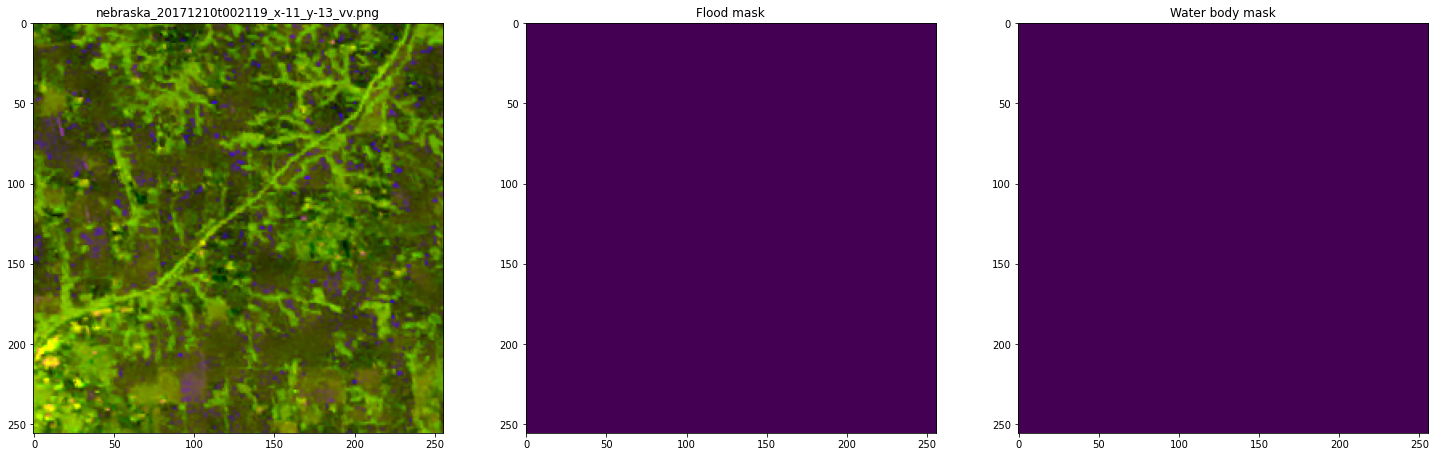

In [ ]:
visualize(train_df.iloc[16501])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


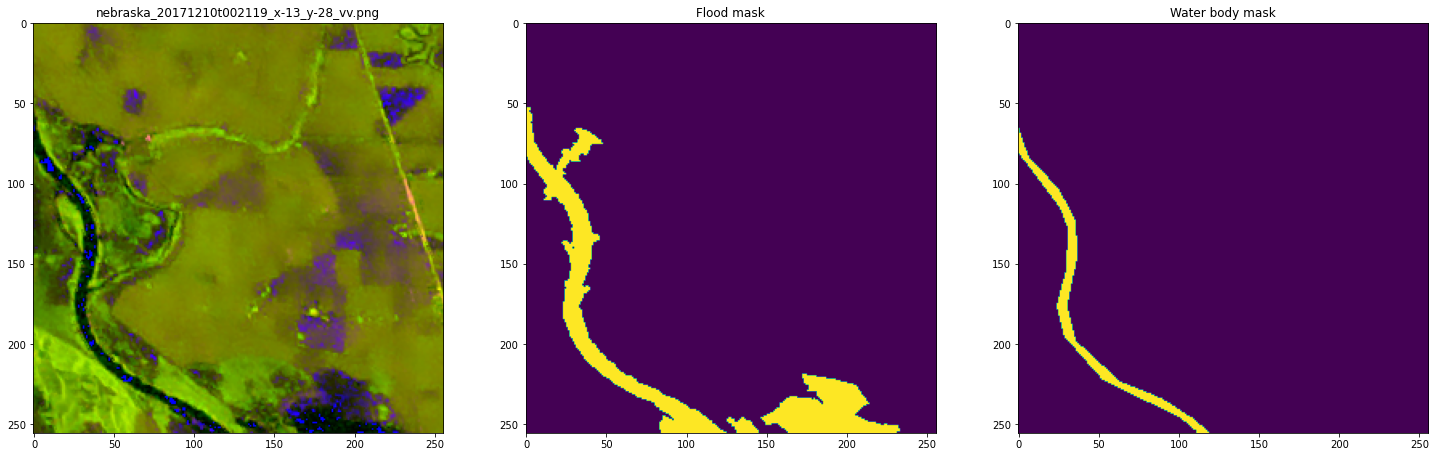

In [ ]:
visualize(train_df.iloc[16601])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide


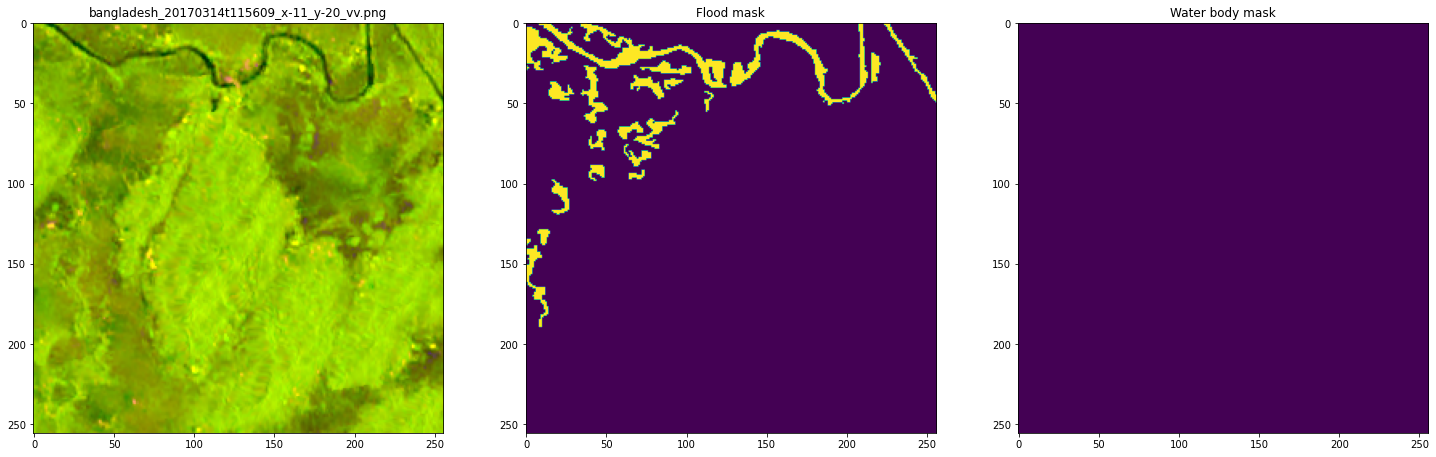

In [ ]:
visualize(train_df.iloc[100])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


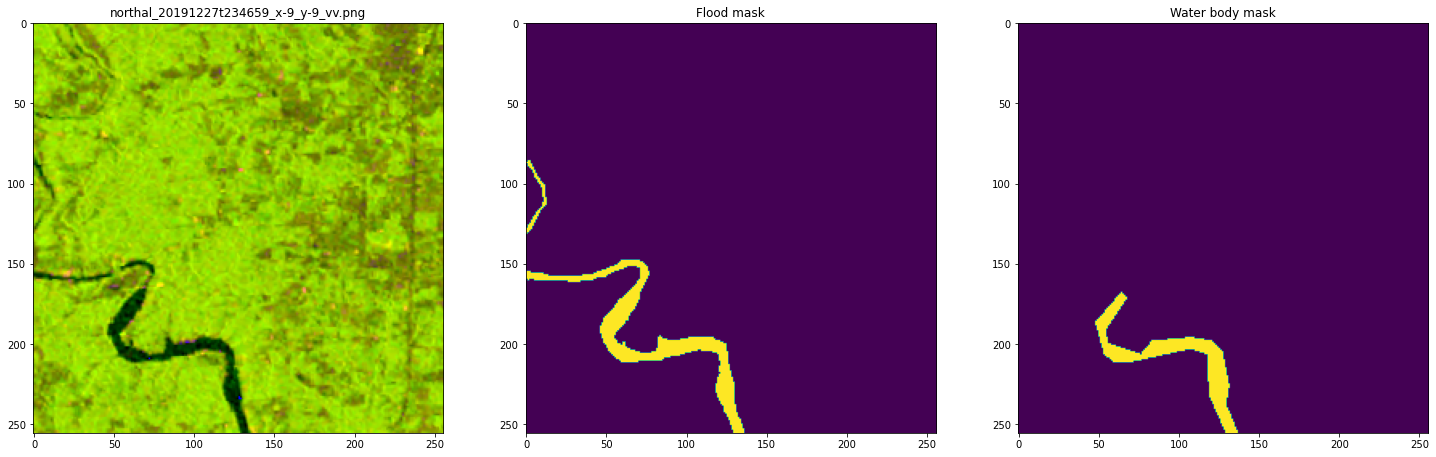

In [ ]:
visualize(train_df.iloc[-1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide


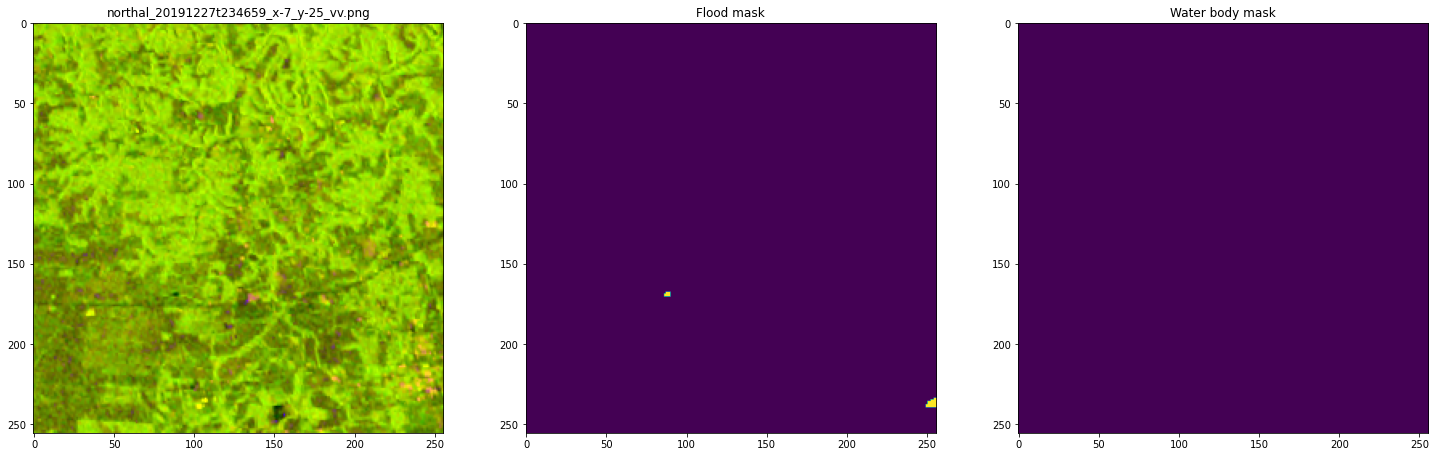

In [ ]:
visualize(train_df.iloc[-100])

### Validation set

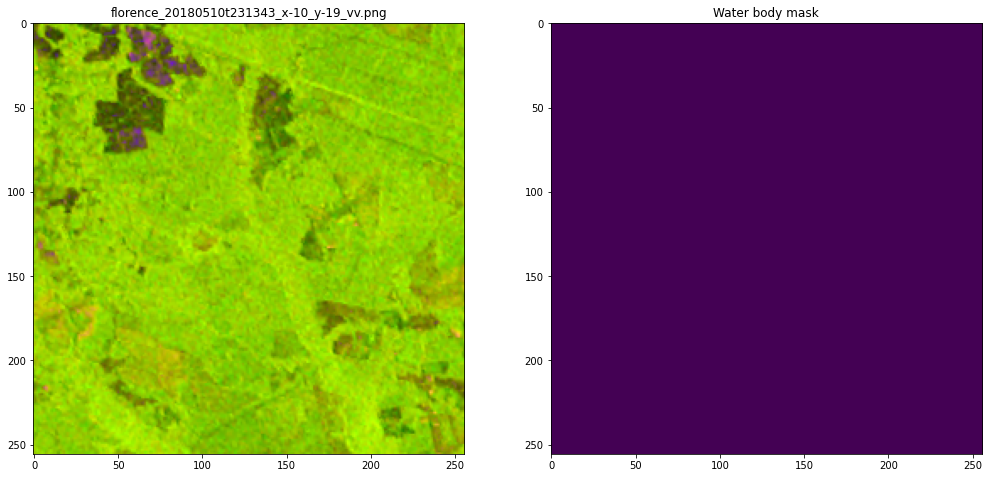

In [ ]:
visualize(valid_df.iloc[50], figsize=(17,10))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


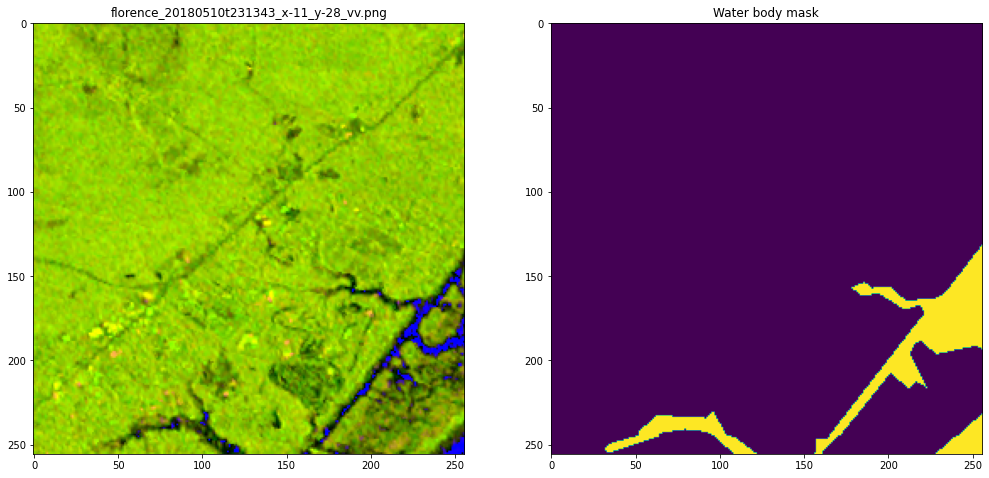

In [ ]:
visualize(valid_df.iloc[100], figsize=(17,10))

### Create a PyTorch dataset

In [ ]:
class ETCIDataset(Dataset):
    def __init__(self, dataframe, split, transform=None):
        self.split = split
        self.dataset = dataframe
        self.transform = transform

    def __len__(self):
        return self.dataset.shape[0]


    def __getitem__(self, index):
        example = {}
        
        df_row = self.dataset.iloc[index]

        # load vv and vh images
        vv_image = cv2.imread(df_row['vv_image_path'], 0) / 255.0
        vh_image = cv2.imread(df_row['vh_image_path'], 0) / 255.0
        
        # convert vv and ch images to rgb
        rgb_image = s1_to_rgb(vv_image, vh_image)

        if self.split == 'test':
            # no flood mask should be available
            example['image'] = rgb_image.transpose((2,0,1)).astype('float32')
        else:
            # load ground truth flood mask
            flood_mask = cv2.imread(df_row['flood_label_path'], 0) / 255.0

            # compute transformations
            if self.transform:
                augmented = self.transform(image=rgb_image, mask=flood_mask)
                rgb_image = augmented['image']
                flood_mask = augmented['mask']

            example['image'] = rgb_image.transpose((2,0,1)).astype('float32')
            example['mask'] = flood_mask.astype('int64')

        return example



In [ ]:
import albumentations as A

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomResizedCrop(width=256, height=256)
])

train_dataset = ETCIDataset(sub_train_df, split='train', transform=transform)
development_dataset = ETCIDataset(development_df, split='devlopment', transform=None)

In [ ]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
development_loader = DataLoader(development_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Create a deep learning model

In [ ]:
device = 'cuda'  # use 'cpu' if your computer does not have a GPU

In [ ]:
def create_model():
  # load model from package
  model = smp.Unet(
      encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
      encoder_weights=None,           # use `imagenet` pre-trained weights for encoder initialization
      in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
      classes=2,                      # model output channels (number of classes in your dataset)
  )
  return model

model = create_model()

In [ ]:
# load model into GPU or CPU memory
model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

### Get model optimizer and loss function

In [ ]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

criteria = nn.CrossEntropyLoss()

# Train model

In [ ]:
# set the number of times you want the model to see all of the training data
epochs = 2

### Metric tracker

In [ ]:
from sklearn.metrics import confusion_matrix

class iouTracker:
    def __init__(self, n_classes=2, smooth=0.0001):
        self.n_classes = n_classes
        self.reset()
        self.smooth = smooth

    def reset(self):
        self.cm = np.zeros((self.n_classes, self.n_classes))
        self.count = 0
    
    def update(self, pred, target):
        self.count += pred.shape[0]

        # reshape inputs
        pred = pred.argmax(dim=1).flatten()  # [B*H*W]
        target = target.flatten()  # [B*H*W]

        # put into cpu memory
        pred = pred.detach().cpu().numpy()
        target = target.detach().cpu().numpy()

        # compute confusion matrix values
        self.cm += confusion_matrix(target, pred)

    def get_mean(self):
        tn, fp, fn, tp = self.cm.ravel()

        # compute IoU
        iou = tp / (tp + fp + fn + self.smooth)

        return iou

### Training and testing

In [ ]:
for epoch in range(epochs):
    print('Epoch: [{}/{}]'.format(epoch+1, epochs))

    # train set
    pbar = tqdm(train_loader)
    model.train()
    iou_logger = iouTracker()
    for batch in pbar:
        # load image and mask into device memory
        image = batch['image'].to(device)
        mask = batch['mask'].to(device)

        # pass images into model
        pred = model(image)

        # get loss
        loss = criteria(pred, mask)

        # update the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # compute and display progress
        iou_logger.update(pred, mask)
        mIoU = iou_logger.get_mean()
        pbar.set_description('Loss: {0:1.4f} | mIoU {1:1.4f}'.format(loss.item(), mIoU))

    # development set
    pbar = tqdm(development_loader)
    model.eval()
    iou_logger = iouTracker()
    with torch.no_grad():
        for batch in pbar:
            # load image and mask into device memory
            image = batch['image'].to(device)
            mask = batch['mask'].to(device)

            # pass images into model
            pred = model(image)

            # get loss
            loss = criteria(pred, mask)
            
            # compute and display progress
            iou_logger.update(pred, mask)
            mIoU = iou_logger.get_mean()
            pbar.set_description('Loss: {0:1.4f} | mIoU {1:1.4f}'.format(loss.item(), mIoU))

            


Epoch: [1/2]


  0%|          | 0/288 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


  0%|          | 0/234 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide


Epoch: [2/2]


  0%|          | 0/288 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


  0%|          | 0/234 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide


# Test model

In [ ]:
# load model
model = create_model()
model.load_state_dict(torch.load('model.pt'))
model.to(device)

valid_dataset = ETCIDataset(valid_df, split='test', transform=None)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)  # make sure shuffle is False

final_predictions = []

model.eval()
with torch.no_grad():
    for batch in tqdm(valid_loader):
        # load image and mask into device memory
        image = batch['image'].to(device)

        # pass images into model
        pred = model(image)

# check final prediction shape
print(final_predictions.shape)

  0%|          | 0/163 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide


(10400, 256, 256)


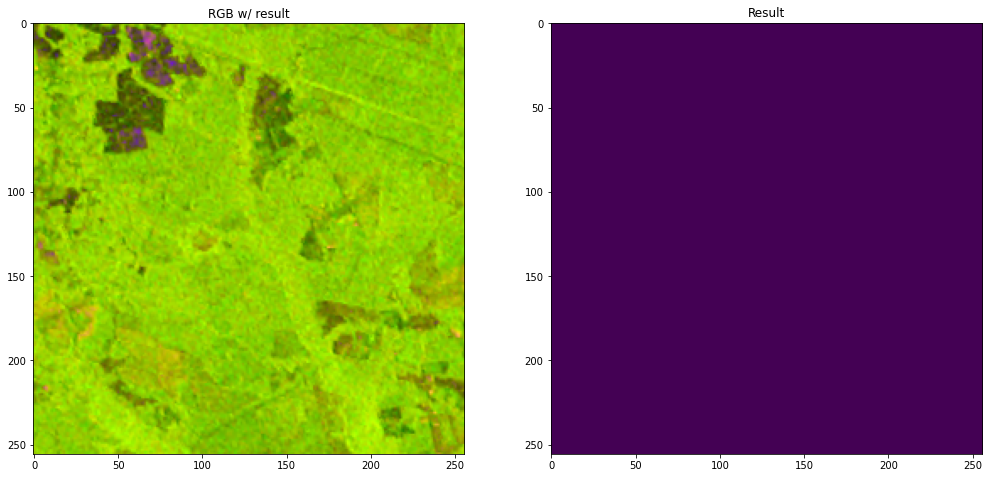

In [ ]:
index = 50
visualize_result(valid_df.iloc[index], final_predictions[index], figsize=(17,10))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


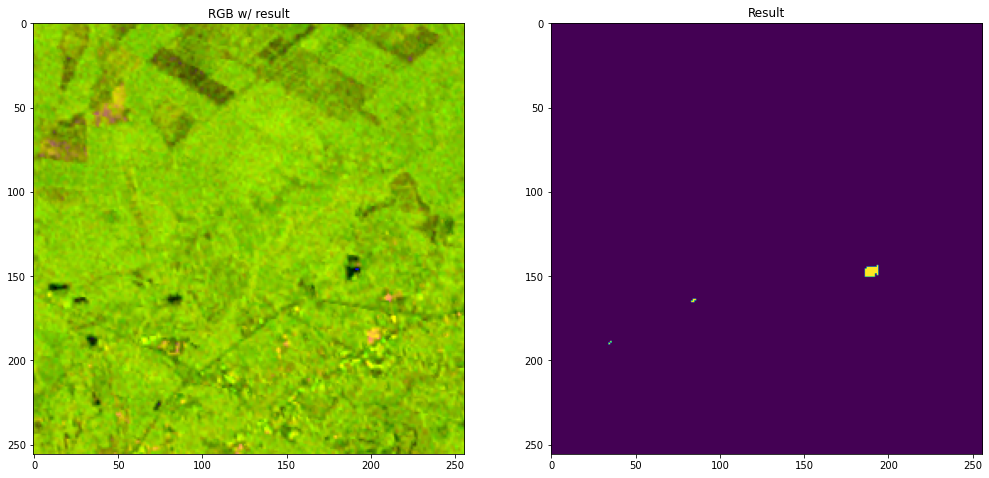

In [ ]:
index = 252
visualize_result(valid_df.iloc[index], final_predictions[index], figsize=(17,10))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide


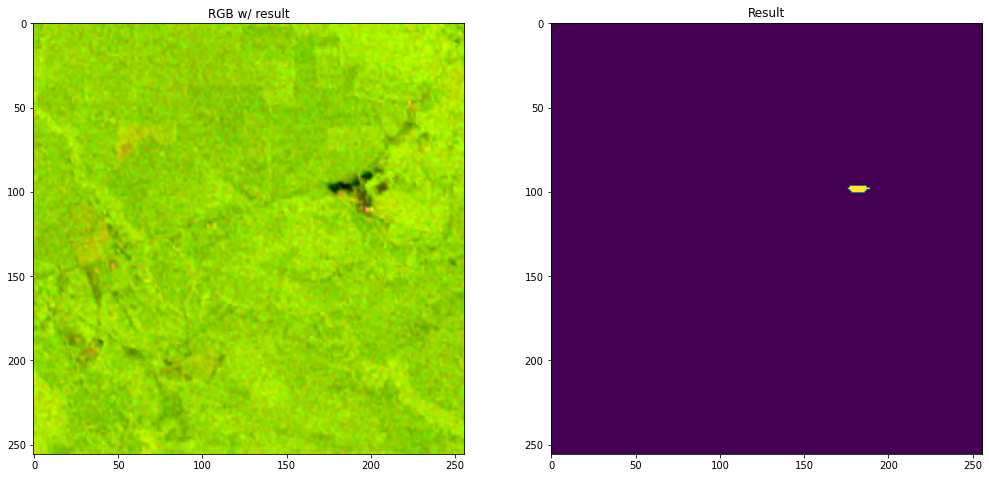

In [ ]:
index = -100
visualize_result(valid_df.iloc[index], final_predictions[index], figsize=(17,10))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide


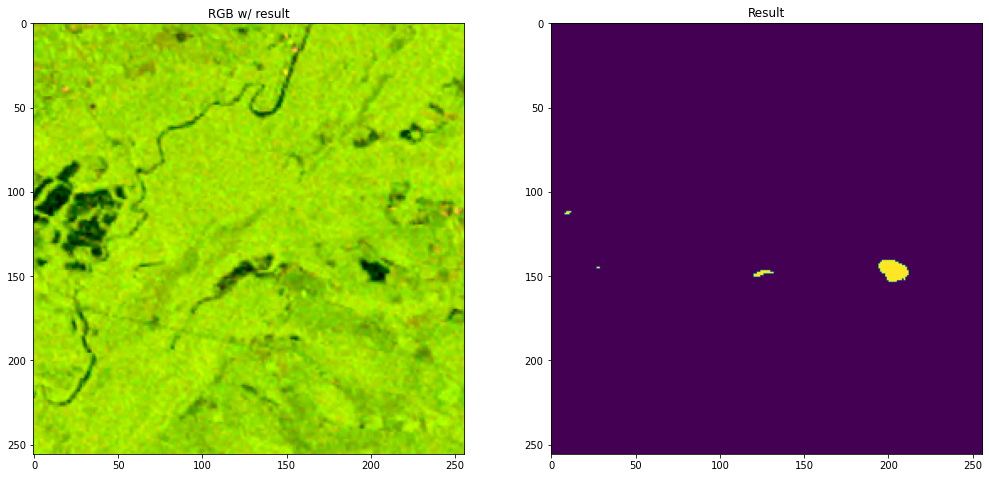

In [ ]:
index = -1919
visualize_result(valid_df.iloc[index], final_predictions[index], figsize=(17,10))